In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz

import rdata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Measurement & Misclassification

Most projects have these problems

### Pancake Problem

- 3 Pancakes with 0 Burnt sides, 1 Burnt side, 2 Burnt sides

- If you receive a pancake with a burnt side up, what is the probability that the other side is burnt?

- Very unintuitive solution. 

$Pr(burnt down | burnt up) = \frac{Pr(burnt up, burnt down)}{Pr(burnt up)}$

$ Pr(burnt up) = (1/3)(1) + (1/3)(0/5) + (1/3)(0) = 1/2$

$Pr(burnt down|burnt up) = (1/3)/(1/2) = 2/3$

Use the rules and apply them

## The Importance of Not Being Clever

Being clever is unreliable and opaque

Better to follow the axioms

Probability theory provides solutions to challenging problems, if only we'll follow the rules

Often nothing else to "understand"

## Measurement Error

Many variables are proxies of the causes of interest

Common to ignore measurement

Many ad hoc procedures

Think causally, lean on probability theory

### Myth: Measurement error only reduces effect estimates, never increases them

Measurement error can have diverse effects on effect estimates, can increase the estimates or non-linearly impact it

In [2]:
N = 500
P = np.random.normal(size=N)
C = np.random.normal(0*P,size=N)
Pstar = np.random.normal(0.8*P + 0.2*C)

In [3]:
with pm.Model() as mCP:
    sigma = pm.Exponential('sigma',1)
    b     = pm.Normal('b',0,1)
    a     = pm.Normal('a',0,1)
    mu    = a + b*Pstar #Not using actual P because simulating bias
    
    Cobs  = pm.Normal('Cobs',mu,sigma,observed=C)
    
    mCP_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([<AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

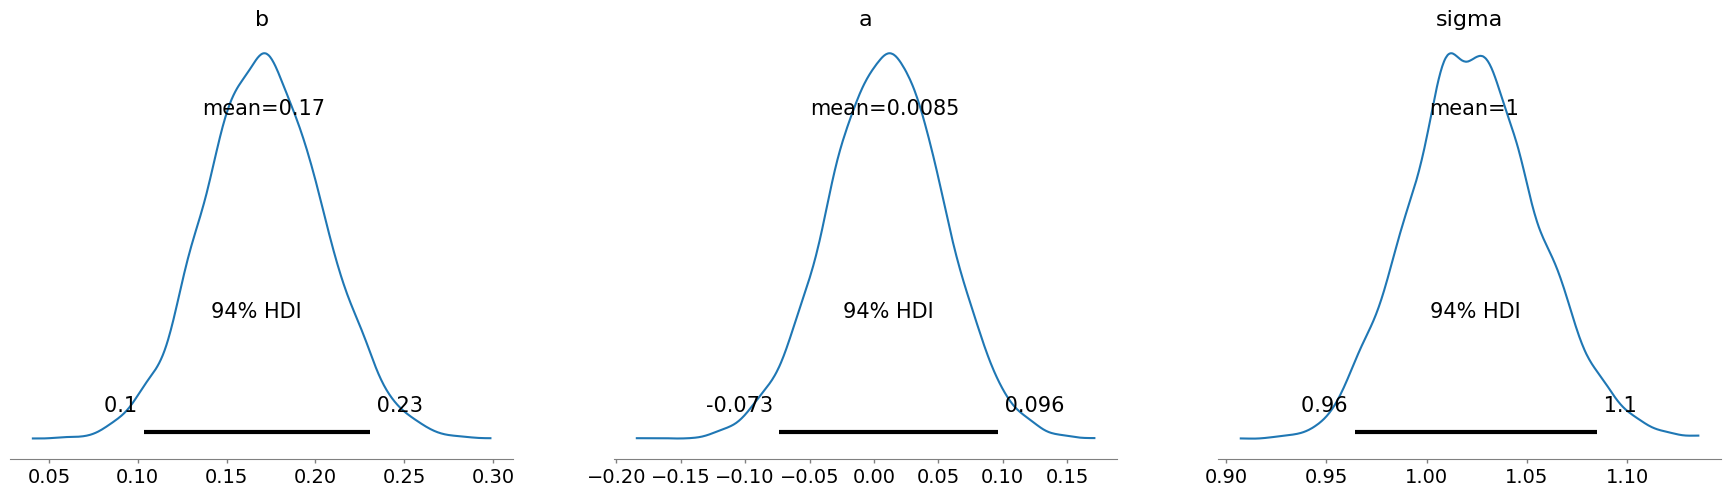

In [4]:
az.plot_posterior(mCP_trace)
# The real simulated effect is 0, but recall bias has called a 
# ghost causal effect

In [5]:
N = 500
P = np.random.normal(size=N)
C = np.random.normal(0.75*P,size=N)
Pstar = np.random.normal(0.8*P + 0.2*C)

with pm.Model() as mCP:
    sigma = pm.Exponential('sigma',1)
    b     = pm.Normal('b',0,1)
    a     = pm.Normal('a',0,1)
    mu    = a + b*Pstar #Not using actual P because simulating bias
    
    Cobs  = pm.Normal('Cobs',mu,sigma,observed=C)
    
    mCP_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([<AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

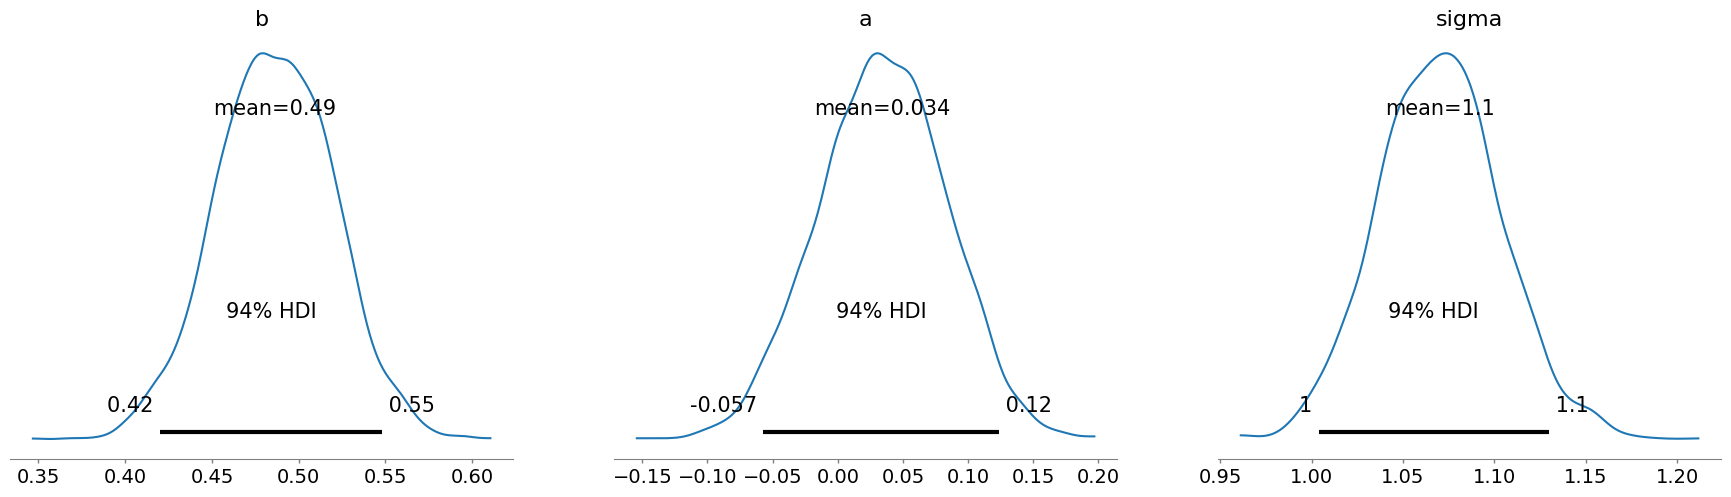

In [6]:
az.plot_posterior(mCP_trace)
# The real simulated effect is 0.75,recall bias has attenuated it

## NO GENERAL RULE ABOUT WHAT MEASUREMENT ERROR WILL DO

## Modelling Measurement

data(WaffleDivorce)

State estimates D, M, A measured with error, error varies by State

Two problems:

1) Imbalance in evidence

2) Potential confounding

In [7]:
waffle = pd.read_csv('Data/WaffleDivorce.csv',sep=';')
waffle.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Text(0, 0.5, 'Divorce rate')

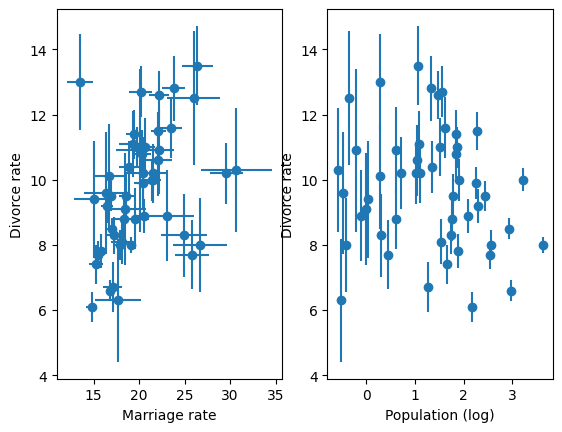

In [8]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

ax0.errorbar(x=waffle['Marriage'],
            y = waffle['Divorce'],
            yerr=waffle['Divorce SE'],
            xerr=waffle['Marriage SE'],
            fmt='o')
ax0.set_xlabel('Marriage rate')
ax0.set_ylabel('Divorce rate')

ax1.errorbar(x=np.log(waffle['Population']),
             y=waffle['Divorce'],
             yerr=waffle['Divorce SE'],
            fmt='o')
ax1.set_xlabel('Population (log)')
ax1.set_ylabel('Divorce rate')

Error bars smaller for states with larger populations, much more data. 

In [9]:
m = graphviz.Digraph()

m.edge('M','D')
m.edge('M','M*')
m.edge('A','M')
m.edge('A','D')
m.edge('D','D*')
m.edge('eD','D*')
m.edge('eM','M*')
m.edge('eA','A*')
m.edge('A','A*')

m.edge('P','eM')
m.edge('P','eD')
#m.edge
m

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Thinking Like a Graph

Regressions (GLMMs) are special case machines

Thinking like a regression: Which predictor variables do I use?

Thinking like a graph: How do I model the network of causes?

"Full luxury bayes"

Every dag can imply multiple estimands. Models in models!

Model for D

Model for D*

Model for M 

$D_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_AA_i+\beta_MM_i$

${D^*}_{i} = D_i + e_{D,i}$

$e_{D,i} \sim Normal(0,Si)$

OR 

${D^*}_{i} \sim Normal(D_i,S_i)$

In [16]:
with pm.Model() as m15_1:
    D_obs = pm.MutableData('D_obs',scale(waffle['Divorce']))
    D_sd  = pm.MutableData('D_sd',waffle['Divorce SE']/np.std(waffle['Divorce SE']))
    M     = pm.MutableData('M',scale(waffle['Marriage']))
    A     = pm.MutableData('A',scale(waffle['MedianAgeMarriage']))
    N     = pm.MutableData('N',waffle.shape[0])
    
    #Model for D (unobserved)
    sigma = pm.Exponential('sigma',1)
    
    bM    = pm.Normal('bM',0,0.5)
    bA    = pm.Normal('bA',0,0.5)
    a     = pm.Normal('a',0,0.2)
    mu    = a + bA*A +bM*M
    
    
    D_true = pm.Normal('D_true',mu,sigma)
    
    #Model for D* (observed)
    D_star = pm.Normal('D_star',D_true, D_sd,observed=D_obs)
    
    m15_1_trace = pm.sample(draws=4000,tune=2000,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a, D_true]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 591 seconds.


## In Bayes unobserved: Parameter
Observed: Data

In [17]:
 az.summary(m15_1_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.267,0.301,-0.199,0.938,0.033,0.039,102.0,16.0,1.04
bA,-0.540,0.243,-0.979,-0.108,0.013,0.009,352.0,1920.0,1.01
a,-0.111,0.131,-0.341,0.150,0.006,0.004,552.0,1662.0,1.02
D_true[0],0.258,0.292,-0.255,0.839,0.012,0.008,580.0,1941.0,1.01
D_true[1],0.685,0.485,-0.118,1.618,0.053,0.050,98.0,122.0,1.04
D_true[2],0.031,0.260,-0.454,0.559,0.008,0.006,1023.0,1365.0,1.01
D_true[3],1.113,0.472,0.306,2.020,0.062,0.051,66.0,1434.0,1.05
D_true[4],-0.578,0.224,-1.012,-0.157,0.006,0.004,1506.0,3086.0,1.01
D_true[5],0.298,0.355,-0.333,0.931,0.028,0.025,164.0,1734.0,1.03
D_true[6],-1.018,0.312,-1.624,-0.434,0.012,0.008,657.0,2173.0,1.01


In [18]:
D_post = az.summary(m15_1_trace, var_names=['D_true'])['mean'].values
D_post

array([ 0.258,  0.685,  0.031,  1.113, -0.578,  0.298, -1.018, -0.142,
       -1.877, -0.511,  0.131, -0.145,  1.514, -0.696,  0.037,  0.271,
        0.487,  0.602,  0.   , -0.717, -0.781, -1.476, -0.51 , -0.589,
       -0.046, -0.024, -0.069,  0.128, -0.68 , -1.258,  0.022, -1.415,
        0.067,  0.676, -0.427,  0.89 , -0.162, -0.911, -1.41 , -0.419,
        0.092,  0.228,  0.345,  1.745, -0.739, -0.246,  0.058,  0.495,
       -0.443,  1.449])

In [19]:
m15_1_trace.posterior.D_true

<xarray.DataArray 'D_true' (chain: 4, draw: 4000, D_true_dim_0: 50)>
array([[[ 3.73232551e-01,  8.79667827e-02,  6.91964393e-02, ...,
          4.37239196e-01, -4.96212327e-02,  4.14343740e-01],
        [ 3.73232551e-01,  8.79667827e-02,  6.91964393e-02, ...,
          4.37239196e-01, -4.96212327e-02,  4.14343740e-01],
        [ 3.73232551e-01,  8.79667827e-02,  6.91964393e-02, ...,
          4.37239196e-01, -4.96212327e-02,  4.14343740e-01],
        ...,
        [-4.17769683e-02,  6.21580531e-01, -2.61173368e-01, ...,
          3.50848506e-01, -4.77235709e-01,  1.23136150e+00],
        [ 9.32805238e-02,  6.39842515e-01, -3.46611037e-02, ...,
          2.51888068e-01, -2.67858867e-01,  1.47440791e+00],
        [-1.99669745e-02,  7.43500364e-01, -2.42844402e-04, ...,
          2.33567224e-01, -4.69055663e-01,  1.36531632e+00]],

       [[ 3.40334350e-01,  4.71833882e-01, -3.95189531e-01, ...,
          2.77927008e-01, -6.89539789e-02,  1.32016598e+00],
        [ 1.51946802e-01,  2.90792093e-01,  4.29291179e-01, ...,
          5.37903528e-01, -8.36360893e-01,  1.37132874e+00],
        [ 3.13502144e-01,  1.04914159e+00,  1.72902541e-01, ...,
          8.86731753e-01, -5.77331704e-02,  1.40248514e+00],
...
        [ 4.46879717e-01,  1.05563057e+00,  1.70714994e-01, ...,
          5.94955238e-01, -2.91162577e-01,  1.68990366e+00],
        [ 2.42851219e-01,  7.63859882e-01,  1.52971374e-01, ...,
          6.24964180e-01, -4.98209875e-01,  1.25761421e+00],
        [ 3.04681637e-01,  1.78260750e-01, -2.07666549e-01, ...,
          3.01852046e-01, -4.77098429e-01,  1.29175204e+00]],

       [[ 2.76975751e-01,  5.17375120e-01,  7.00600461e-02, ...,
          6.63889271e-01, -1.18384626e-01,  1.36237908e+00],
        [ 4.08999364e-01,  4.26790395e-01, -1.46741430e-02, ...,
          4.96188735e-01, -3.99752648e-01,  1.49157226e+00],
        [ 2.86451181e-01,  4.47845318e-01, -7.35842213e-02, ...,
          5.79689465e-01, -3.26887145e-01,  9.58542420e-01],
        ...,
        [-2.27429913e-01,  4.71488780e-01, -1.16123483e-01, ...,
          2.58487002e-01, -7.32473134e-01,  1.47782088e+00],
        [-2.53070850e-01,  8.55157247e-01, -3.15857414e-01, ...,
          3.53499990e-02, -7.93642305e-01,  1.79292790e+00],
        [ 6.53172693e-02,  6.27603335e-01,  1.22407350e-02, ...,
          2.79105866e-01, -6.69318523e-01,  1.49339416e+00]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * D_true_dim_0  (D_true_dim_0) int32 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49

<AxesSubplot: >

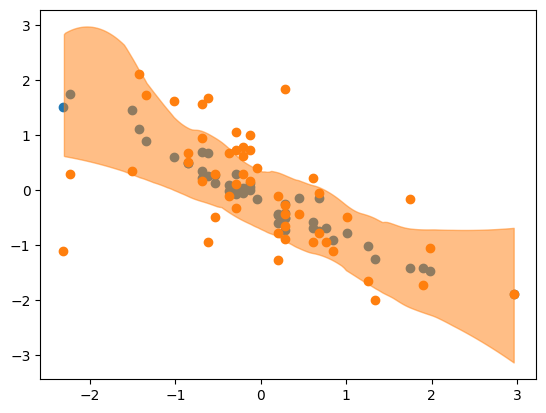

In [20]:
plt.scatter(x=scale(waffle['MedianAgeMarriage']),
           y = D_post,
           )

plt.scatter(x=scale(waffle['MedianAgeMarriage']),
           y =scale(waffle['Divorce']),
           )

az.plot_hdi(x=scale(waffle['MedianAgeMarriage']),
           y=m15_1_trace.posterior.D_true)

#partially pooled! For free!

${M^*}_{i} \sim Normal(M_i,T_i)$

$M_i \sim Normal(v_i,\tau)$

$v_i = \alpha_M +B_{AM}A_i$

In [21]:
with pm.Model() as m15_2:
    D     = pm.MutableData('D',scale(waffle['Divorce']))
    D_sd  = pm.MutableData('D_sd',waffle['Divorce SE']/np.std(waffle['Divorce SE']))
    M     = pm.MutableData('M',scale(waffle['Marriage']))
    M_sd  = pm.MutableData('M_sd',waffle['Marriage SE']/np.std(waffle['Marriage SE']))
    A     = pm.MutableData('A',scale(waffle['MedianAgeMarriage']))
    N     = pm.MutableData('N',waffle.shape[0])
    
    #Model for M
    tau = pm.Exponential('tau',1)
    bAM = pm.Normal('bAM',0,0.5)
    aM  = pm.Normal('aM',0,0.2)
    
    nu  = aM + bAM*A
    
    M_true = pm.Normal('M_true',nu,tau,size=50)
    
    #Model for M*
    
    M_obs = pm.Normal('M_obs',M_true,M_sd,observed=M)
    
    #Model for D (unobserved)
    sigma = pm.Exponential('sigma',1)
    
    bM    = pm.Normal('bM',0,0.5)
    bA    = pm.Normal('bA',0,0.5)
    a     = pm.Normal('a',0,0.2)
    
    mu    = a + bA*A +bM*M_true
    
    
    D_true = pm.Normal('D_true',mu,sigma,size=50)
    
    #Model for D* (observed)
    D_obs = pm.Normal('D_obs',D_true, D_sd,observed=D)
    
    m15_2_trace = pm.sample(draws=4000,tune=2000,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, bAM, aM, M_true, sigma, bM, bA, a, D_true]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 279 seconds.


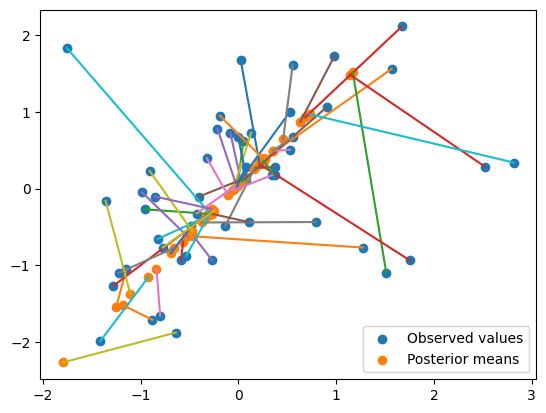

In [22]:
D_post = az.summary(m15_2_trace, var_names=['D_true'])['mean'].values

M_post = az.summary(m15_2_trace, var_names=['M_true'])['mean'].values

plt.plot([M_post, scale(waffle['Marriage'])],
           [D_post,scale(waffle['Divorce'])],
           )
plt.scatter(scale(waffle['Marriage']),
            scale(waffle['Divorce']),
            label='Observed values'
           )


plt.scatter(M_post,D_post,
           label='Posterior means')

plt.legend()
#az.plot_hdi(x=scale(waffle['MedianAgeMarriage']),
#           y=m15_1_trace.posterior.D_true)

#partially pooled! For free!
#Shrinkage towards the trend line
#Points furthest from the trend line are of poorer quality
#Points furthest from the trend line are more extreme, so get pulled more
#UNreliable points are downweighted automatically

array([[<AxesSubplot: title={'center': 'bA'}>,
        <AxesSubplot: title={'center': 'bA'}>],
       [<AxesSubplot: title={'center': 'bM'}>,
        <AxesSubplot: title={'center': 'bM'}>]], dtype=object)

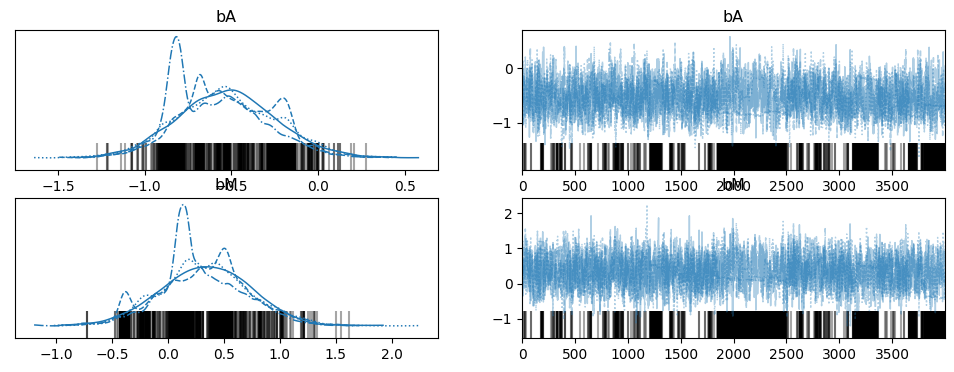

In [23]:
az.plot_trace(m15_2_trace,var_names=['bA','bM']) #Traces look okayish

In [24]:
az.summary(m15_2_trace,var_names=['bA','bM'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.541,0.281,-1.019,0.010,0.012,0.008,576.0,2886.0,1.01
bM,0.323,0.397,-0.427,1.059,0.012,0.009,1046.0,358.0,1.01


Running all the models in the same chain leads to them sharing information. 

## Unpredictable errors

Including error on M increases evidence for an effeect of M on D

Why?

Down-weighting of unreliabl estimates

Errors can hurt or help, but only honest option is to attend to them. 

Bantu pastoralists

50k people, 50k km^2

Bilineal descent

Matrilineal inheritance

Patrilineal status

Patrilocality

Polygyny common

"Open" marriages

## Misclassification

Estimand: Proportion of children fathered by extra-pair men

Problem: 5% false positive rate (sometimes the man is the father, but the DNA test doesn't work)

Mislassification: Categorical version of measurement error

How do we include misclassification? 

If the rate of extra-pair paternity is clsoe to the false positive rate, this is a big problem. 

$X_i \sim Bernoulli(p_i)$

$logit(p_i) = \alpha + \mu_{M[i]} + \delta_{D[i]}$

$Pr(Xi* = 1|p_i) = p_i + (1-p_i)f$

$Pr(Xi = 0|p_i) = (1-p_i(1-f)$

## Don't have this data due to privacy/ethics

In [36]:
with pm.Model() as mX:
    tau = pm.Normal('tau',0,1)
    x = pm.Normal('x',0,1) #Shape would be dyad shape
    
    sigma = pm.Normal('sigma',0,1) 
    z     = pm.Normal('z',0,1) #Shape would be mom_id
    a     = pm.Normal('a',0,1)
    
    p = expit( a + z*sigma +x*tau)
    
    Xi = pm.math.switch(X == 1,log(p+(1-p)*f),log((1-p)*(1-f)))
    #No idea if this is correct, jsut a first pass idea

TypeError: ufunc 'expit' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Floating Point Monsters

Probability calculations tend to underflow (round to zero) and overflow (round to one)

Solution: calculat on log scale

Ancient weapons in R: log_sum_exp, log1m, log1m_exp

## Measurement Horizons

PLenty of related problems and solutions

Rating and assessment: Judges and tests are noisey - item response theory and factor analysis

Hurdle models: Thresholds for detection

Occupancy models: Not detecting something doesn't mean it isn't there 

In [37]:
np.log(1-0.01)

-0.01005033585350145

In [38]:
np.log(1-1e-10)

-1.000000082790371e-10

In [40]:
np.log(1-1e-90) #Should be extremely close to 0, not 0 

0.0

In [41]:
np.log1p(-1e-90) #Gets the correct result!

-1e-90

## Devil in the details

When x < 1e-4, thats where we can get rounding error. We then use a Taylor series approximation (the np.log1p)

In [44]:
np.logaddexp(1,1)

1.6931471805599454